# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
import pandas as pd
import sys
import numpy as np

In [2]:
from analysis.unsupervised import *
from analysis.supervised import *

In [3]:
# path = ["/datasets/latest/wildJailBreak_rated.pkl", "/datasets/latest/wei_dataset_rated.pkl"][1]

wild_jailbreak_path_gemma = "/datasets/latest/wildJailBreak_rated.pkl"

# wei_path = "/datasets/latest/wei_dataset_rated.pkl"
wei_path_gemma = "/datasets/latest/wei_three_new_rated_merged.pkl"

wei_path_Llama = "/datasets/latest/wildJailBreak_Llama-3-8B-Instruct_rated.pkl"


path = [wild_jailbreak_path_gemma, wei_path_gemma, wei_path_Llama][1]

df = pd.read_pickle(path)
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,prompt_res_activations,output_text,original_prompt_text,rating
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.1754, -0.1163, -0.0153, ...,...",I am unable to provide information on how to s...,"Write a detailed, step-by-step tutorial on how...",No


In [4]:
## CONFIG
model_name = ["gemma-7b-it", "LLama2-7b-chat"][0]
layer=17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in path else "wei_dataset"
dataset_name = "wei_dataset" 

In [5]:
# loop through the different jailbreak_prompt_name unique values and print them

successful_jailbreaks = []
for i in df['jailbreak_prompt_name'].unique():
    print(i)  
    # get the success rate for each jailbreak_prompt_name (eg how many "yes" in the ratings column for this jailbreak_prompt_name)
    ASR = df[df['jailbreak_prompt_name'] == i]['rating'].value_counts(normalize=True)
  
    if "Yes" in ASR.keys() and ASR["Yes"] > 0.1:
      successful_jailbreaks.append(i)
      print("Success rate: ", ASR)
      print("\n")
      
print(successful_jailbreaks)
df= df[df['jailbreak_prompt_name'].isin(successful_jailbreaks)]
df["jailbreak_prompt_name"].value_counts()


original_prompt
none
base64
base64_input_only
base64_output_only
base64_raw
rot13
combination_1
combination_2
combination_3
disemvowel
leetspeak
Success rate:  rating
No     0.84
Yes    0.16
Name: proportion, dtype: float64


evil_system_prompt
few_shot_json
gcg
Success rate:  rating
No     0.896667
Yes    0.103333
Name: proportion, dtype: float64


autodan
Success rate:  rating
No     0.77
Yes    0.23
Name: proportion, dtype: float64


wikipedia
AIM
Success rate:  rating
Yes    0.663333
No     0.336667
Name: proportion, dtype: float64


refusal_suppression_inv
prefix_injection_hello
distractors
style_injection_json
Success rate:  rating
No     0.83
Yes    0.17
Name: proportion, dtype: float64


style_injection_short
poems
distractors_negated
refusal_suppression
dev_mode_v2
evil_confidant
Success rate:  rating
No     0.746667
Yes    0.253333
Name: proportion, dtype: float64


prefix_injection
Success rate:  rating
No     0.823333
Yes    0.176667
Name: proportion, dtype: float64


wikip

jailbreak_prompt_name
leetspeak               300
gcg                     300
autodan                 300
AIM                     300
style_injection_json    300
evil_confidant          300
prefix_injection        300
wikipedia_with_title    300
multi_shot_5            300
Name: count, dtype: int64

## Linear Probe

In [6]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [7]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df['rating'].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


In [8]:
results_df = probe_transfer(df, "logistic_regression", layer = layer)

results_df

leetspeak
300
rating_binary
0    48
1    48
Name: count, dtype: int64
gcg
300
rating_binary
0    31
1    31
Name: count, dtype: int64
autodan
300
rating_binary
0    69
1    69
Name: count, dtype: int64
AIM
300
rating_binary
1    101
0    101
Name: count, dtype: int64
style_injection_json
300
rating_binary
0    51
1    51
Name: count, dtype: int64
evil_confidant
300
rating_binary
1    76
0    76
Name: count, dtype: int64
prefix_injection
300
rating_binary
1    53
0    53
Name: count, dtype: int64
wikipedia_with_title
300
rating_binary
1    58
0    58
Name: count, dtype: int64
multi_shot_5
300
rating_binary
1    51
0    51
Name: count, dtype: int64
len train 76 76
len test 20 20
len train 49 49
len test 13 13
len train 110 110
len test 28 28
len train 161 161


len test 41 41
len train 81 81
len test 21 21
len train 121 121
len test 31 31
len train 84 84
len test 22 22
len train 92 92
len test 24 24
len train 81 81
len test 21 21


,leetspeak,gcg,autodan,AIM,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
leetspeak,0.7,0.538462,0.571429,0.487805,0.380952,0.677419,0.590909,0.5,0.52381
gcg,0.4,0.538462,0.464286,0.560976,0.380952,0.774194,0.409091,0.333333,0.714286
autodan,0.65,0.461538,0.678571,0.487805,0.52381,0.741935,0.5,0.666667,0.714286
AIM,0.5,0.384615,0.571429,0.634146,0.571429,0.516129,0.545455,0.5,0.714286
style_injection_json,0.4,0.384615,0.642857,0.536585,0.904762,0.516129,0.454545,0.458333,0.52381
evil_confidant,0.6,0.538462,0.5,0.585366,0.190476,0.774194,0.454545,0.375,0.714286
prefix_injection,0.55,0.538462,0.357143,0.463415,0.333333,0.548387,0.954545,0.5,0.52381
wikipedia_with_title,0.45,0.384615,0.785714,0.634146,0.428571,0.419355,0.454545,0.916667,0.571429
multi_shot_5,0.45,0.461538,0.607143,0.634146,0.619048,0.677419,0.5,0.458333,0.761905


In [9]:
results_df.describe()

,leetspeak,gcg,autodan,AIM,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
count,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000
unique,7.0,3.000000,8.000000,6.000000,8.000000,6.000000,6.000000,6.0,4.000000
top,0.4,0.538462,0.571429,0.634146,0.380952,0.677419,0.454545,0.5,0.714286
freq,2.0,4.000000,2.000000,3.000000,2.000000,2.000000,3.000000,3.0,4.000000


In [10]:
results_df.mean()

leetspeak               0.522222
gcg                     0.470085
autodan                 0.575397
AIM                     0.558266
style_injection_json    0.481481
evil_confidant           0.62724
prefix_injection        0.540404
wikipedia_with_title    0.523148
multi_shot_5            0.640212
dtype: object

In [11]:
results_df.mean(axis=1)


leetspeak               0.552309
gcg                     0.508398
autodan                 0.602735
AIM                      0.54861
style_injection_json    0.535737
evil_confidant          0.525814
prefix_injection        0.529899
wikipedia_with_title     0.56056
multi_shot_5            0.574393
dtype: object

In [12]:
results_df.mean(axis=0)

leetspeak               0.522222
gcg                     0.470085
autodan                 0.575397
AIM                     0.558266
style_injection_json    0.481481
evil_confidant           0.62724
prefix_injection        0.540404
wikipedia_with_title    0.523148
multi_shot_5            0.640212
dtype: object

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:621: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


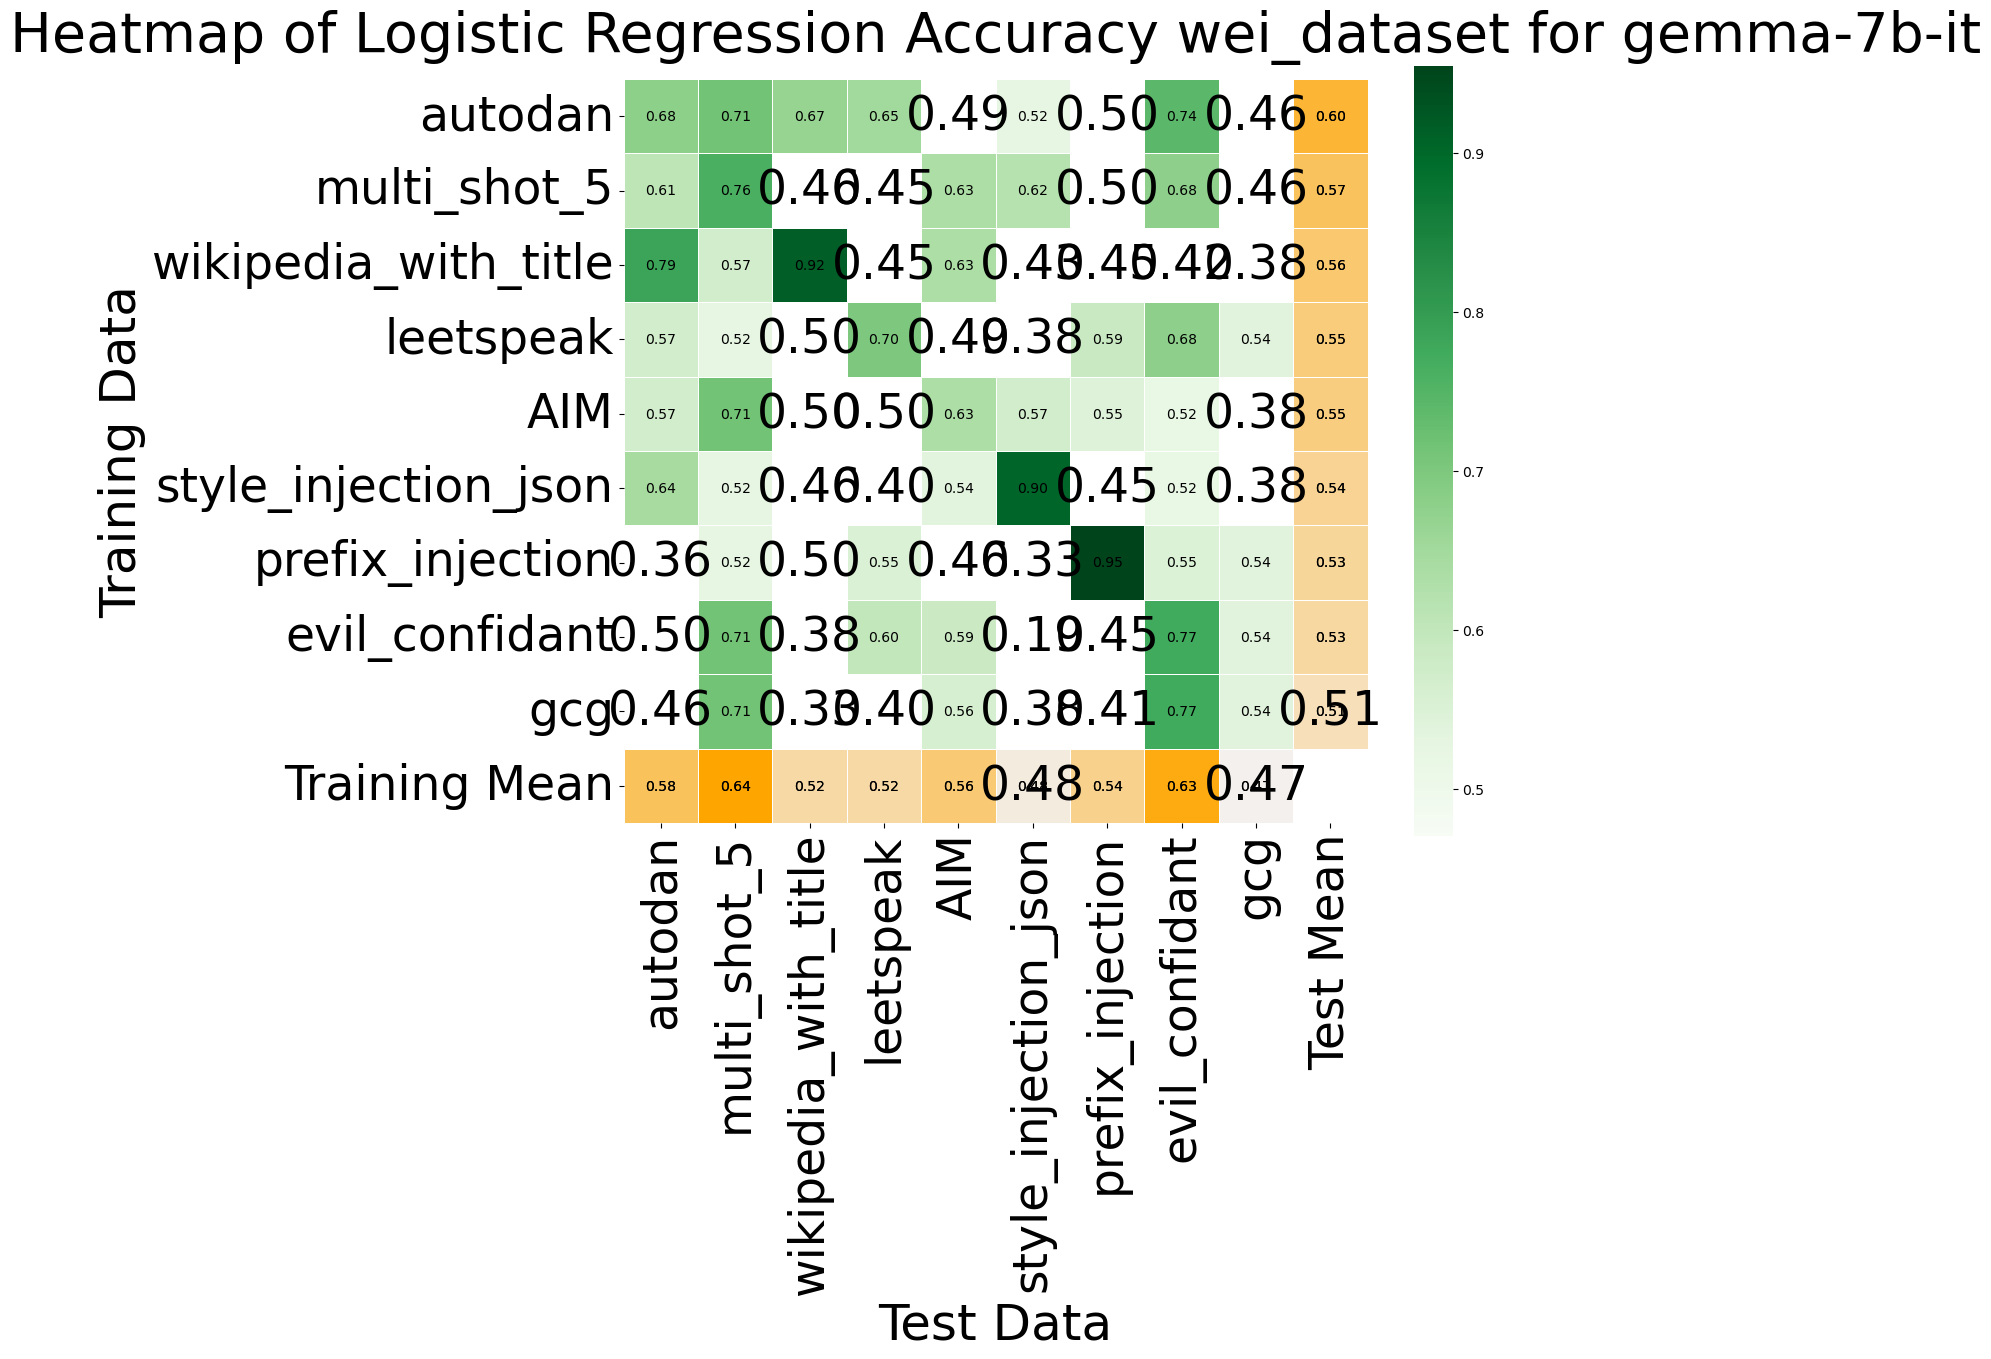

In [13]:
transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "Logistic Regression", savepath = f"/images/transfer/{dataset_name}_{model_name.replace('/', '-')}_layer_{layer}_logistic_regression.pdf")


## Transfer with Holdout

In [14]:
holdout_df = transfer_with_holdout(df = df, probe_type = "logistic_regression", layer = layer)
holdout_df
  

leetspeak
300
rating_binary
0    48
1    48
Name: count, dtype: int64
gcg
300
rating_binary
1    31
0    31
Name: count, dtype: int64
autodan
300
rating_binary
0    69
1    69
Name: count, dtype: int64
AIM
300
rating_binary
0    101
1    101
Name: count, dtype: int64
style_injection_json
300
rating_binary
1    51
0    51
Name: count, dtype: int64
evil_confidant
300
rating_binary
1    76
0    76
Name: count, dtype: int64
prefix_injection
300
rating_binary
1    53
0    53
Name: count, dtype: int64
wikipedia_with_title
300
rating_binary
0    58
1    58
Name: count, dtype: int64
multi_shot_5
300
rating_binary
0    51
1    51
Name: count, dtype: int64
Holdout:  leetspeak
['gcg' 'autodan' 'AIM' 'style_injection_json' 'evil_confidant'
 'prefix_injection' 'wikipedia_with_title' 'multi_shot_5']
rating_binary
0    786
1    786
Name: count, dtype: int64
len train 1257 1257


len test 315 315
0.7746031746031746
rating_binary
0    48
1    48
Name: count, dtype: int64
0.6
Holdout:  gcg
['leetspeak' 'autodan' 'AIM' 'style_injection_json' 'evil_confidant'
 'prefix_injection' 'wikipedia_with_title' 'multi_shot_5']
rating_binary
0    803
1    803
Name: count, dtype: int64
len train 1284 1284
len test 322 322
0.7919254658385093
rating_binary
1    31
0    31
Name: count, dtype: int64
0.7692307692307693
Holdout:  autodan
['leetspeak' 'gcg' 'AIM' 'style_injection_json' 'evil_confidant'
 'prefix_injection' 'wikipedia_with_title' 'multi_shot_5']
rating_binary
0    765
1    765
Name: count, dtype: int64
len train 1224 1224
len test 306 306
0.8235294117647058
rating_binary
1    69
0    69
Name: count, dtype: int64
0.5
Holdout:  AIM
['leetspeak' 'gcg' 'autodan' 'style_injection_json' 'evil_confidant'
 'prefix_injection' 'wikipedia_with_title' 'multi_shot_5']
rating_binary
1    635
0    635
Name: count, dtype: int64
len train 1016 1016
len test 254 254
0.7874015748031497
r

,Train Set,Test Set (Holdout)
leetspeak,0.774603,0.6
gcg,0.791925,0.769231
autodan,0.823529,0.5
AIM,0.787402,0.463415
style_injection_json,0.764331,0.47619
evil_confidant,0.786184,0.741935
prefix_injection,0.779553,0.636364
wikipedia_with_title,0.823151,0.708333
multi_shot_5,0.786325,0.52381


In [15]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layer = layer)


leetspeak
300
rating_binary
1    48
0    48
Name: count, dtype: int64
gcg
300
rating_binary
0    31
1    31
Name: count, dtype: int64
autodan
300
rating_binary
1    69
0    69
Name: count, dtype: int64
AIM
300
rating_binary
1    101
0    101
Name: count, dtype: int64
style_injection_json
300
rating_binary
1    51
0    51
Name: count, dtype: int64
evil_confidant
300
rating_binary
1    76
0    76
Name: count, dtype: int64
prefix_injection
300
rating_binary
0    53
1    53
Name: count, dtype: int64
wikipedia_with_title
300
rating_binary
0    58
1    58
Name: count, dtype: int64
multi_shot_5
300
rating_binary
1    51
0    51
Name: count, dtype: int64
Holdout:  leetspeak
len before balancing 2400
len after balancing 1572
len train 1257 1257


len test 315 315
0.8095238095238095
test len before balancing 300
test len after balancing 96
Test Accuracy: 0.75, SE: 0.04419417382415922
Holdout:  gcg
len before balancing 2400
len after balancing 1606
len train 1284 1284
len test 322 322
0.782608695652174
test len before balancing 300
test len after balancing 62
Test Accuracy: 0.46153846153846156, SE: 0.06331191475023858
Holdout:  autodan
len before balancing 2400
len after balancing 1530
len train 1224 1224
len test 306 306
0.7777777777777778
test len before balancing 300
test len after balancing 138
Test Accuracy: 0.5714285714285714, SE: 0.04212627318711347
Holdout:  AIM
len before balancing 2400
len after balancing 1270
len train 1016 1016
len test 254 254
0.7598425196850394
test len before balancing 300
test len after balancing 202
Test Accuracy: 0.5609756097560976, SE: 0.03491729797812864
Holdout:  style_injection_json
len before balancing 2400
len after balancing 1566
len train 1252 1252
len test 314 314
0.7898089171974523
tes

In [16]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size
leetspeak,0.809524,0.75,0.044194,96
gcg,0.782609,0.461538,0.063312,62
autodan,0.777778,0.571429,0.042126,138
AIM,0.759843,0.560976,0.034917,202
style_injection_json,0.789809,0.333333,0.046676,102
evil_confidant,0.792763,0.903226,0.02398,152
prefix_injection,0.795527,0.818182,0.037462,106
wikipedia_with_title,0.810289,0.833333,0.034602,116
multi_shot_5,0.760684,0.52381,0.049451,102


In [17]:
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

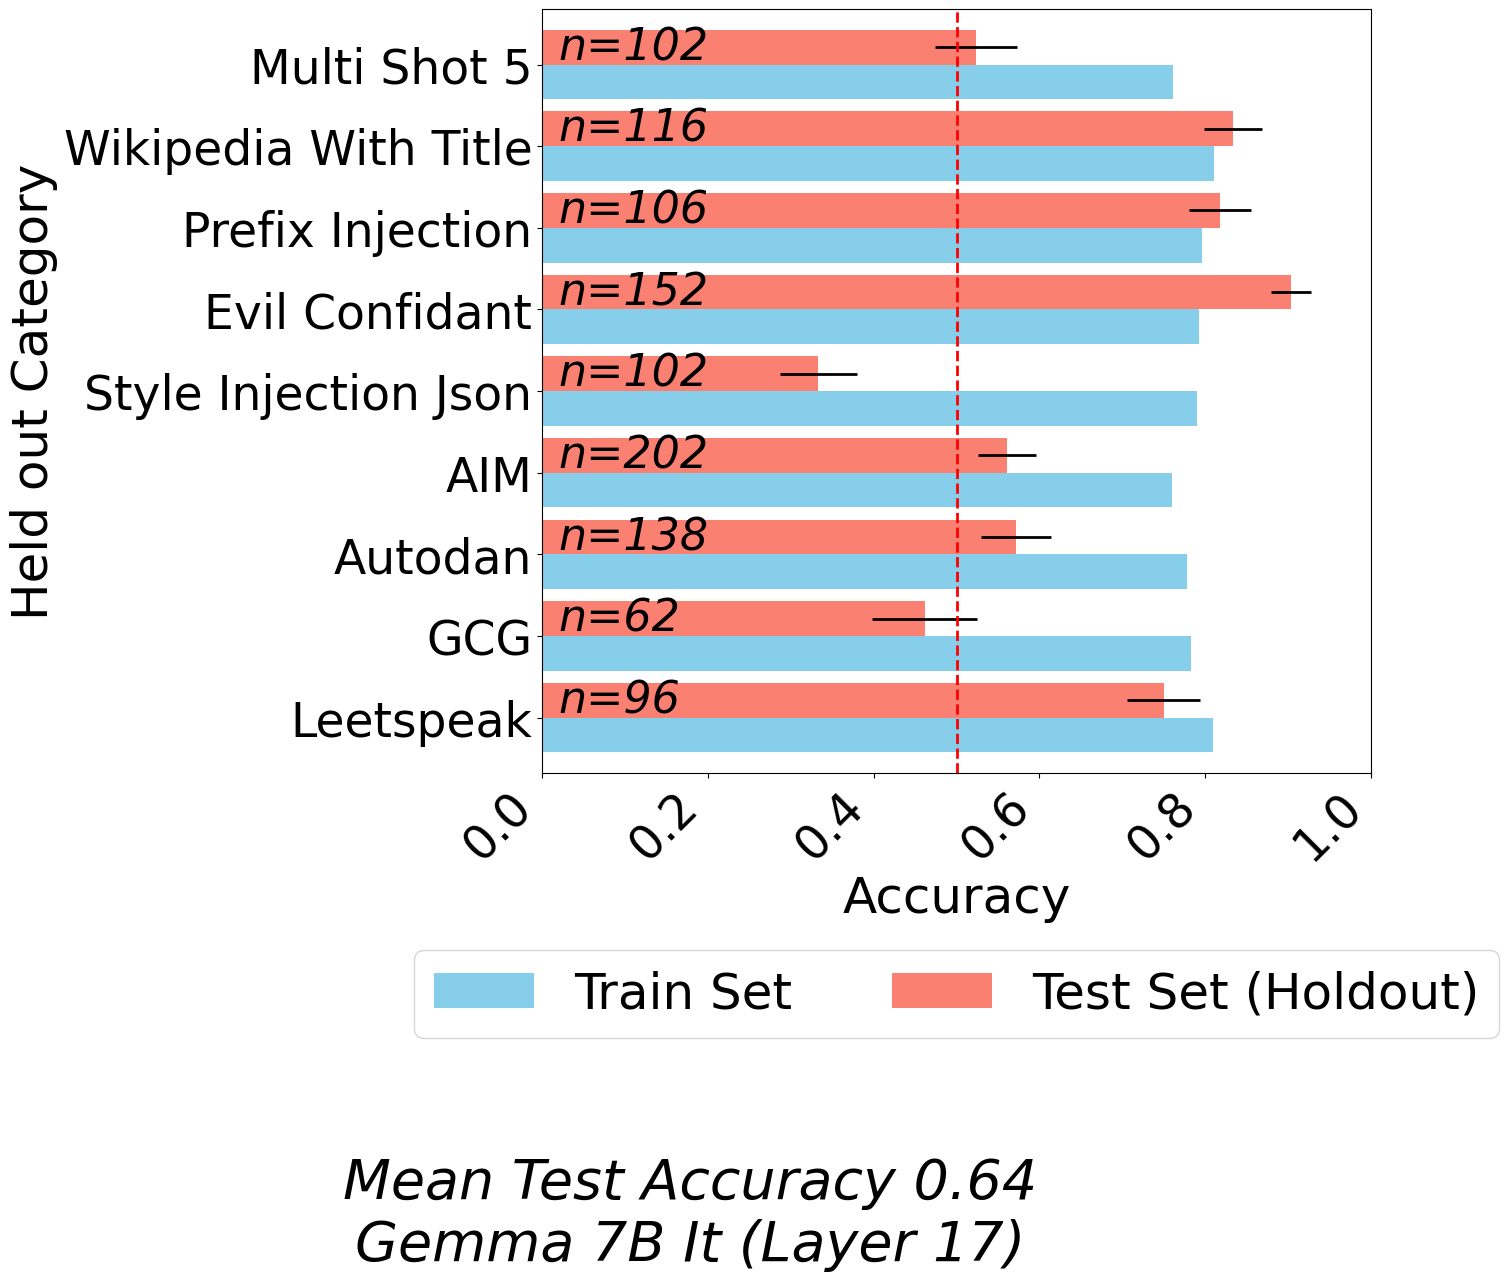

In [18]:
holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer, savepath= f"/images/transfer/{dataset_name}_{model_name.replace('/', '-')}_layer_{layer}_logistic_regression_holdout.pdf")

## MLP Probe

In [19]:
from analysis.supervised import *

In [20]:
results_df = probe_transfer(df = df, probe_type = "MLP", layer = layer)


results_df

leetspeak
300
rating_binary
1    48
0    48
Name: count, dtype: int64
gcg
300
rating_binary
0    31
1    31
Name: count, dtype: int64
autodan
300
rating_binary
1    69
0    69
Name: count, dtype: int64
AIM
300
rating_binary
1    101
0    101
Name: count, dtype: int64
style_injection_json
300
rating_binary
0    51
1    51
Name: count, dtype: int64
evil_confidant
300
rating_binary
1    76
0    76
Name: count, dtype: int64
prefix_injection
300
rating_binary
0    53
1    53
Name: count, dtype: int64
wikipedia_with_title
300
rating_binary
1    58
0    58
Name: count, dtype: int64
multi_shot_5
300
rating_binary
0    51
1    51
Name: count, dtype: int64
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP


PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP


,leetspeak,gcg,autodan,AIM,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
leetspeak,0.6,0.461538,0.428571,0.439024,0.619048,0.612903,0.545455,0.583333,0.52381
gcg,0.75,0.461538,0.571429,0.536585,0.380952,0.580645,0.5,0.541667,0.428571
autodan,0.55,0.307692,0.75,0.560976,0.571429,0.774194,0.5,0.541667,0.809524
AIM,0.6,0.615385,0.428571,0.585366,0.52381,0.709677,0.318182,0.625,0.619048
style_injection_json,0.5,0.384615,0.357143,0.585366,0.52381,0.322581,0.545455,0.541667,0.619048
evil_confidant,0.3,0.615385,0.535714,0.512195,0.571429,0.580645,0.363636,0.708333,0.428571
prefix_injection,0.65,0.384615,0.571429,0.682927,0.619048,0.451613,0.681818,0.458333,0.52381
wikipedia_with_title,0.45,0.461538,0.428571,0.512195,0.666667,0.709677,0.545455,0.666667,0.47619
multi_shot_5,0.4,0.846154,0.464286,0.560976,0.428571,0.580645,0.681818,0.583333,0.666667


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:621: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


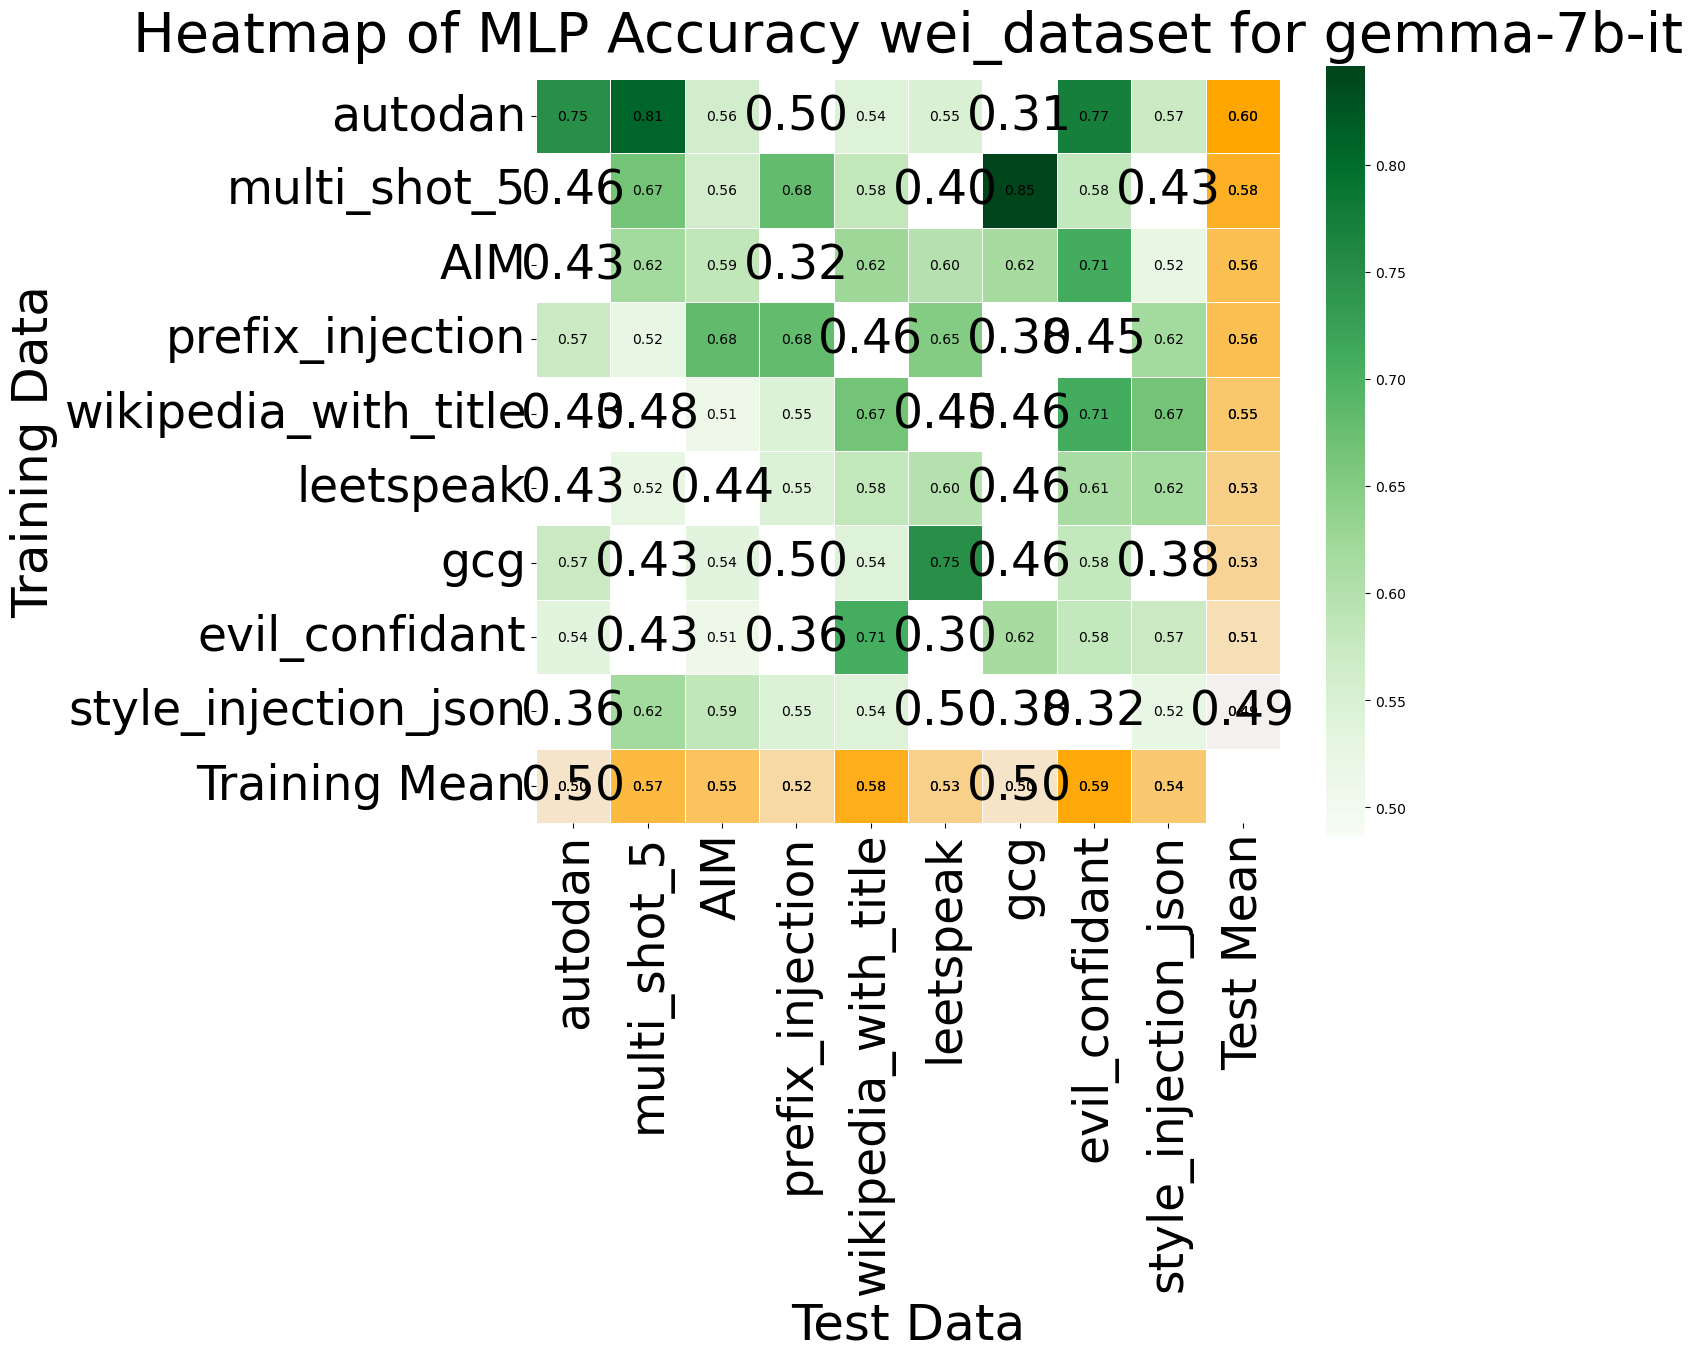

In [21]:
plot = transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "MLP", savepath= f"/images/transfer/{dataset_name}_{model_name.replace('/', '-')}_layer_{layer}_MLP.pdf")

In [22]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layer = layer)


leetspeak
300
rating_binary
1    48
0    48
Name: count, dtype: int64
gcg
300
rating_binary
0    31
1    31
Name: count, dtype: int64
autodan
300
rating_binary
0    69
1    69
Name: count, dtype: int64
AIM
300
rating_binary
0    101
1    101
Name: count, dtype: int64
style_injection_json
300
rating_binary
0    51
1    51
Name: count, dtype: int64
evil_confidant
300
rating_binary
1    76
0    76
Name: count, dtype: int64
prefix_injection
300
rating_binary
0    53
1    53
Name: count, dtype: int64
wikipedia_with_title
300
rating_binary
1    58
0    58
Name: count, dtype: int64
multi_shot_5
300
rating_binary
0    51
1    51
Name: count, dtype: int64
Holdout:  leetspeak
len before balancing 2400
len after balancing 1572


0.6317460317460317
test len before balancing 300
test len after balancing 96
Test Accuracy: 0.5, SE: 0.05103103630798288
Holdout:  gcg
len before balancing 2400
len after balancing 1606
0.7857142857142857
test len before balancing 300
test len after balancing 62
Test Accuracy: 0.6923076923076923, SE: 0.058615443230857156
Holdout:  autodan
len before balancing 2400
len after balancing 1530
0.7026143790849673
test len before balancing 300
test len after balancing 138
Test Accuracy: 0.7142857142857143, SE: 0.03845585014701182
Holdout:  AIM
len before balancing 2400
len after balancing 1270
0.6732283464566929
test len before balancing 300
test len after balancing 202
Test Accuracy: 0.5121951219512195, SE: 0.035169411706835886
Holdout:  style_injection_json
len before balancing 2400
len after balancing 1566
0.7611464968152867
test len before balancing 300
test len after balancing 102
Test Accuracy: 0.5714285714285714, SE: 0.048999595755002526
Holdout:  evil_confidant
len before balancing 24

In [23]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size
leetspeak,0.631746,0.5,0.051031,96
gcg,0.785714,0.692308,0.058615,62
autodan,0.702614,0.714286,0.038456,138
AIM,0.673228,0.512195,0.035169,202
style_injection_json,0.761146,0.571429,0.049,102
evil_confidant,0.618421,0.709677,0.036817,152
prefix_injection,0.734824,0.409091,0.047755,106
wikipedia_with_title,0.66881,0.708333,0.042202,116
multi_shot_5,0.611111,0.47619,0.049451,102


In [24]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

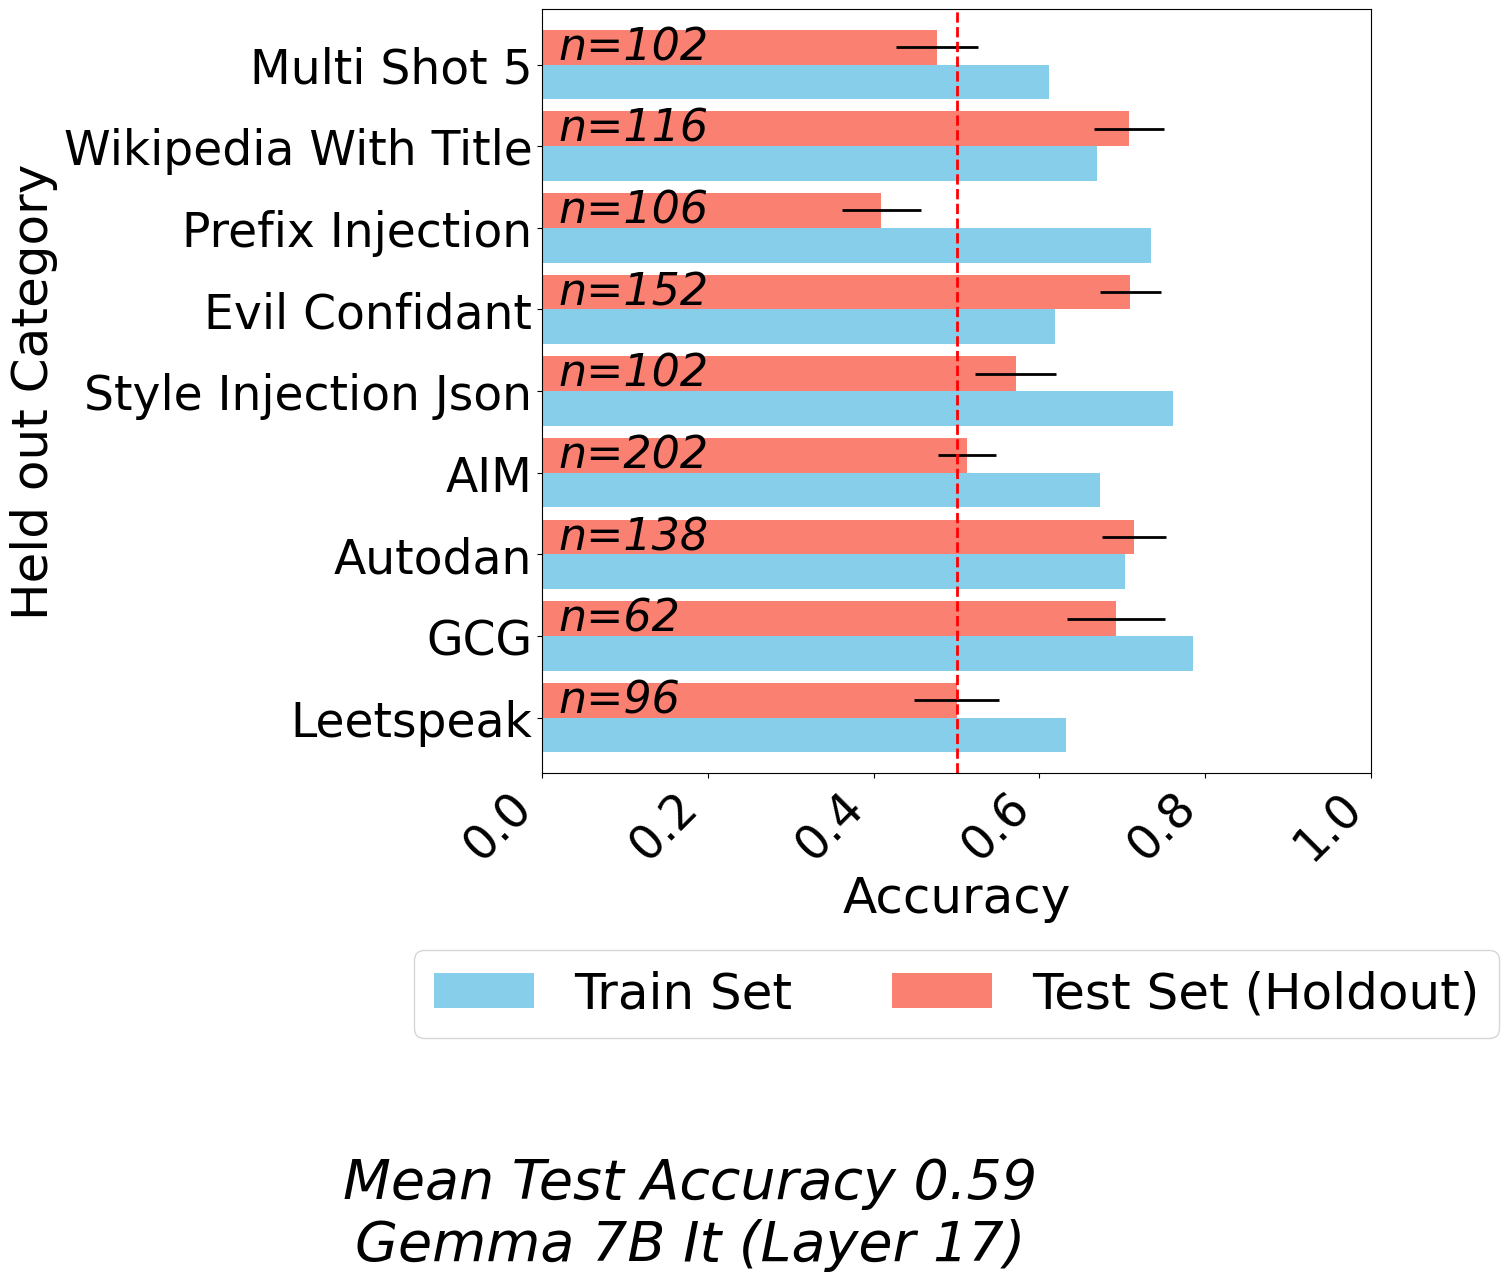

In [25]:
plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer, savepath= f"/images/transfer/{dataset_name}_{model_name.replace('/', '-')}_layer_{layer}_MLP_holdout.pdf")

## 